# Test data reading and preprocessing for fetal brain segmentation

In [1]:
import os
import sys
import tempfile
from glob import glob
import logging

import nibabel as nib
import numpy as np
import torch
from matplotlib import pyplot as plt
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator, _prepare_batch
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader

monai_old = False
if monai_old:
    sys.path.append("/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/MONAI")
import monai
from monai.data import NiftiDataset, list_data_collate
from monai.transforms import Compose, LoadNiftid, AddChanneld, NormalizeIntensityd, Resized, \
     RandSpatialCropd, RandRotated, RandFlipd, SqueezeDimd, SplitChanneld, ToTensord
from monai.transforms.compose import Transform, MapTransform
from monai.handlers import \
    StatsHandler, TensorBoardStatsHandler, TensorBoardImageHandler, MeanDice, stopping_fn_from_metric
from monai.networks.utils import predict_segmentation
from monai.utils import set_determinism

# from ipynb.fs.full.io_utils import create_data_list
sys.path.append("/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/src/")
from io_utils import create_data_list

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

cuda_device=1
torch.cuda.set_device(cuda_device)
set_determinism(seed=2)

MONAI version: 0.2.0
Python version: 3.7.4 (default, Jul  9 2019, 03:52:42)  [GCC 5.4.0 20160609]
Numpy version: 1.18.2
Pytorch version: 1.4.0

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.1
Tensorboard version: 2.2.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Create training and validation data list

In [2]:
# list folders to search for the data
data_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupA", 
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupB1",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupB2", 
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupC",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupD",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupE",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupF", 
            ""]

# list of subject IDs to search for data
list_root = "/mnt/data/mranzini/Desktop/GIFT-Surg/Retraining_with_expanded_dataset/config/file_names"
training_list = os.path.join(list_root, "list_train_files.txt")
validation_list = [os.path.join(list_root, "list_validation_h_files.txt"),
                   os.path.join(list_root, "list_validation_p_files.txt")]

# 
train_files = create_data_list(data_folder_list=data_root, 
                               subject_list=training_list, 
                               img_postfix='_Image', 
                               label_postfix='_Label')

print(len(train_files))
print(train_files[0])
print(train_files[-1])

val_files = create_data_list(data_folder_list=data_root, 
                             subject_list=validation_list, 
                             img_postfix='_Image', 
                             label_postfix='_Label')
print(len(val_files))
print(val_files[0])
print(val_files[-1])

# np.savetxt("images_training.txt", images_training, fmt='%s')
# np.savetxt("seg_training.txt", seg_training, fmt='%s')
# np.savetxt("images_validation.txt", images_validation, fmt='%s')
# np.savetxt("seg_validation.txt", seg_validation, fmt='%s')

316
{'img': '/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupA/a01_02_Image.nii.gz', 'seg': '/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupA/a01_02_Label.nii.gz', 'mask': []}
{'img': '/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupE/E18_02_Image.nii.gz', 'seg': '/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupE/E18_02_Label.nii.gz', 'mask': []}
50
{'img': '/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupA/a04_02_Image.nii.gz', 'seg': '/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupA/a04_02_Label.nii.gz', 'mask': []}
{'img': '/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupE/E11_08_Image.nii.gz', 'seg': '/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupE/E11_08_Label.nii.gz', 'mask': []}


## Setup transforms, dataset

In [3]:
##### MY DEFINITION OF TRANSFORMS BEFORE THEY WERE ADDED TO MONAI
# define transforms for image and segmentation
# class SqueezeDim(Transform):
#     """
#     Remove last dimension
#     """

#     def __init__(self, dim=None):
#         """
#         Args:
#             dim (int): dimension to be squeezed.
#                 Default: None (all dimensions of size 1 will be removed)
#         """
#         if dim is not None:
#             assert isinstance(dim, int) and dim >= -1, 'invalid channel dimension.'
#         self.dim = dim

#     def __call__(self, img):
#         """
#         Args:
#             data (dict): dictionary of numpy arrays with dim removed,
#         """
#         return np.squeeze(img, self.dim)

    
# class SqueezeDimd(MapTransform):
#     """
#     Dictionary-based wrapper of :py:class:SqueezeDim`.
#     """

#     def __init__(self, keys, dim=None):
#         """
#         Args:
#             keys (hashable items): keys of the corresponding items to be transformed.
#                 See also: :py:class:`monai.transforms.compose.MapTransform`
#             dim (int): dimension to be squeezed.
#                 Default: None (all dimensions of size 1 will be removed)
#         """
#         super().__init__(keys)
#         self.converter = SqueezeDim(dim=dim)

#     def __call__(self, data):
#         d = dict(data)
#         for key in self.keys:
#             d[key] = self.converter(d[key])
#         return d

class ConverToOneHotd(MapTransform):
    """
    Convert multi-class label to One Hot Encoding:
    """
    def __init__(self, keys, labels):
        """
        Args:
            
        """
        super().__init__(keys)
        self.labels = labels
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = list()
            for n in self.labels:
                result.append(d[key] == n)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

/mnt/data/mranzini/environments/monai0.2.0_python3.7/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([2, 1, 96, 96]) torch.Size([2, 1, 96, 96])
Segmentation limits: channel 0
tensor(0.)
tensor(1.)


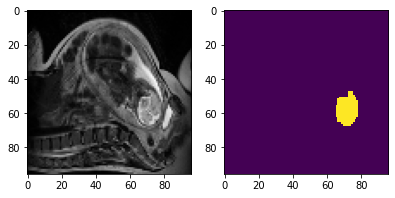

In [4]:
num_classes = 1
labels = [1]

if monai_old:
    # MONAI 0.1.0+84.ga683c4e.dirty
    train_transforms = Compose([
        LoadNiftid(keys=['img', 'seg']),
        ConverToOneHotd(keys=['seg'], labels=labels),
        AddChanneld(keys=['img']),
        NormalizeIntensityd(keys=['img']),  
        Resized(keys=['img', 'seg'], spatial_size=[96, 96], interp_order=[1, 0], anti_aliasing=[True, False]),
        RandSpatialCropd(keys=['img', 'seg'], roi_size=[96, 96, 1], random_size=False),
        RandRotated(keys=['img', 'seg'], degrees=90, prob=0.2, spatial_axes=[0, 1], interp_order=[1, 0], reshape=False),
        RandFlipd(keys=['img', 'seg'], spatial_axis=[0, 1]),
        SqueezeDimd(keys=['img', 'seg'], dim=-1),
        ToTensord(keys=['img', 'seg'])
    ])
else:
    train_transforms = Compose([
        LoadNiftid(keys=['img', 'seg']),
        ConverToOneHotd(keys=['seg'], labels=labels),
        AddChanneld(keys=['img']),
        NormalizeIntensityd(keys=['img']),
        Resized(keys=['img', 'seg'], spatial_size=[96, 96, -1], mode=["trilinear", "nearest"]),
        RandSpatialCropd(keys=['img', 'seg'], roi_size=[96, 96, 1], random_size=False),
        RandRotated(keys=['img', 'seg'], range_x=90, range_y=90, prob=0.2, keep_size=True, mode=["bilinear", "nearest"]),
        RandFlipd(keys=['img', 'seg'], spatial_axis=[0, 1]),
        SqueezeDimd(keys=['img', 'seg'], dim=-1),
        ToTensord(keys=['img', 'seg'])
    ])
                 
check_train_files = train_files[:4]
# print(check_train_files)

# define dataset, data loader
check_ds = monai.data.Dataset(data=check_train_files, transform=train_transforms)
# use batch_size=2 to load images 
check_loader = DataLoader(check_ds, batch_size=2, num_workers=1, collate_fn=list_data_collate,
                          pin_memory=torch.cuda.is_available())

check_data = monai.utils.misc.first(check_loader)
print(check_data['img'].shape, check_data['seg'].shape)


plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(check_data['img'][0, 0, :, :], cmap='gray')
plt.subplot(132)
plt.imshow(check_data['seg'][0, 0, :, :], interpolation="nearest")
print("Segmentation limits: channel 0")
print(torch.min(check_data['seg'][0, 0, :, :]))
print(torch.max(check_data['seg'][0, 0, :, :]))
if num_classes == 2:
    plt.subplot(133)
    plt.imshow(check_data['seg'][0, 1, : , :], interpolation="nearest")
    print("Segmentation limits: channel 1")
    print(torch.min(check_data['seg'][0, 1, :, :]))
    print(torch.max(check_data['seg'][0, 1, :, :]))
########
# val_transforms = Compose([
#     LoadNiftid(keys=['img', 'seg']),
#     AddChanneld(keys=['img', 'seg']),
#     NormalizeIntensityd(keys=['img']),
#     Resized(keys=['img'], spatial_size=[96, 96], order=1),
#     Resized(keys=['seg'], spatial_size=[96, 96], order=0, anti_aliasing=False),
#     ToTensord(keys=['img', 'seg'])
# ])

# # create a training data loader
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
# train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=4,
#                           collate_fn=list_data_collate, pin_memory=torch.cuda.is_available())
# check_train_data = monai.utils.misc.first(train_loader)
# print(check_train_data['img'].shape, check_train_data['seg'].shape)

# # create a validation data loader
# val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
# val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate,
#                         pin_memory=torch.cuda.is_available())

In [ ]:
# check that the two channels are correct
print(check_data['seg'][0, 0, 60, 60:80])
# print(check_data['seg'][0, 1, 60, 60:80])

In [ ]:
import nibabel as nib

count_slices = 0
for f in train_files:
    tmp_nii = nib.load(f['img'])
    tmp_img = tmp_nii.get_fdata()
    count_slices += np.shape(tmp_img)[2]
print(count_slices) 

In [ ]:
320000/count_slices